# Learn Generalizable Representations using Siamese Network

In this notebook, our goal is to learn generalizable representations (features) from a dataset for solving classification problems. Specifically, we intend to create representations that combine two properties: (i) class discriminativeness and (ii) invariance. The latter property is broad, hence we will only focus on the rotation-invariance.

## Approach
For learning generalizable representations, we use the Siamese network architecture, which consists of two types of layers: shared layers and task-specific layers. A Siamese network or Twin network is a neural network architecture that contains two or more identical subnetworks used to generate representations (feature vectors or embeddings) for multiple input samples and compare them. Specifically, the subnetworks learn embeddings of their respective inputs via weight sharing.


We train the Siamese network to solve two classification tasks simultaneously: the main task (predicting the class labels) and an auxiliary task (e.g., predicticting the rotation angles). For solving the auxiliary task, we augment the source dataset (e.g., rotating each image either by 90 degree or 180 degree). During training, the shared layers align the representations of the two datasets.


The Siamese network architecture used in this notebook consists of two identical subnetworks (that contains the shared layers). Inputs of the original task and the auxiliary task are passed through this shared network. At the end of the shared network, a pair of task specific Dense layers is appended for these two tasks, which is followed by a classification layer.
- Original Task (supervised): predict the original label
- Auxiliary task (self-supervised): predict the rotation (angle) of the original image. A new dataset is created that contains rotated versions (by 90 degree or 180 degree) of the original images. Depending on the rotation angle, a new label is attached with each rotated image (label 1 for rotation degree 90, and 2 for rotation degree 180).

The Siamese network is trained to solve these two classification problems using the cross-entropy loss function. At the same time, it tries to minimize the Euclidean distance between the embeddings (at the task-specific layer of the network) of the pairs of images. For distance minimization, the contrastive loss function is used.

After training, the shared layers will create alignment in the representations. Also, the task-specific layers will be forced to share high-level representations, as is desirable for inducing alignment. We expect these representations to be generalizable by combining (i) class discriminativeness and (ii) rotation-invariance. 

Finally, we will use the high-level representations (task-specific layer) for the main task to predict the class labels of the augmented data (i.e., for each rotated image, the network will predict its class label).





## Experiments

Using the Siamese network, we perform three experiments.
- Experiment 1: the Siamese Network Minimizes the Distance of the Pairs of Embeddings via Contrastive Learning
- Experiment 2: the Siamese Network Does not Minimize the Distance of the Pairs of Embeddings
- Experiment 3: a Vanilla Neural Network is Trained on the Original Data 


## Dataset
We use the MNIST fashion dataset.


## Observation
We will see that the Siamese network model in experiment 1 (that minimizes constrastive loss between the high-level representations of two inputs) generalizes better on the augmented data. The performace of the second type of Siamese network model in experiment 2 is also better than the vanilla neural network. Thus unlike the case of MNIST handwritten digits dataset (previous notebook), we are able to learn generalizable representations by using the Siamese network and designing auxialiary task. Of course, the generalization performance is not exciting, but this is due to the nature of the auxialiary task. Had we have included images rotated by angles other than 90 and 180 as well as other types of auxiliary tasks (e.g., flip prediction, patch prediction, etc.), we could have obtained better generalizability from shared representations.

In [ ]:
!pip install tensorflow_addons

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf
import tensorflow_addons as tfa

## Load the Dataset

We load the train and test dataset using Keras datasets API. Then, scale it.

In [ ]:
# Load the MNIST fashion dataset (train and test subsets)
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()


# Split the training set into training & validation subsets
X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]


# The data must be a 4D tensor: sample size, height, width, channels
# Add a single channel for the grayscale images (for RGB images this step is not required)
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_valid = X_valid.reshape((X_valid.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))


# Convert datatype to float32
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')


# Scale the data
X_train = X_train/255.0
X_valid = X_valid/255.0
X_test = X_test/255.0



print("\nShape of Training Samples: ", X_train.shape)
print("Shape of Training Labels: ", y_train.shape)

print("\nShape of Validation Samples: ", X_valid.shape)
print("Shape of Validation Labels: ", y_valid.shape)

print("\nShape of Testing Samples: ", X_test.shape)
print("Shape of Testing Labels: ", y_test.shape)

print("\nData type: ", X_train.dtype)
print("Label type: ", y_train.dtype)


Shape of Training Samples:  (55000, 28, 28, 1)
Shape of Training Labels:  (55000,)

Shape of Validation Samples:  (5000, 28, 28, 1)
Shape of Validation Labels:  (5000,)

Shape of Testing Samples:  (10000, 28, 28, 1)
Shape of Testing Labels:  (10000,)

Data type:  float32
Label type:  uint8


## Functions for Rotating Images

In [ ]:
'''
This function rotates an image randomly by 
either degree "rotation_angle_degree" or "rotation_angle_degree"+90
It returns the rotated image and its "label"
    label = 0: rotation degree = "rotation_angle_degree"
    label = 1: rotation degree = "rotation_angle_degree" + 90
'''
def rotate_randomly(x, rotation_angle_degree):
    
    rand_val = np.random.random_sample()
    label = -1
    if(rand_val < 0.5):
        rotation_angle_radian = rotation_angle_degree * (3.1416/ 180)
        x = tfa.image.rotate(x, rotation_angle_radian, fill_mode='nearest', interpolation='bilinear')
        label = 0
    else:
        rotation_angle_radian = (rotation_angle_degree + 90) * (3.1416/ 180)
        x = tfa.image.rotate(x, rotation_angle_radian, fill_mode='nearest', interpolation='bilinear')
        label = 1
    return x, label



'''
This function takes a data marix X and returns another matrix X_rot of the same shape
X_rot contains rotated versions (by 90 degree or 180 degree) of the images in X
It also returns a label matrix, which assigns 0/1 to each rotated image in X_rot as follows.
    label = 0; if rotation = 90 degree
    label = 1; if rotation = 180 degree
'''
def create_rotated_images_labels(X):
    
    '''
    Create a data matrix to store rotated version of the samples in X 
    '''
    X_rot = X.copy()
    
    '''
    Create a binary label matrix to store the labels of the rotated samples
    in X_rot
    '''
    y_rot = np.zeros((X_rot.shape[0], 2))
    
    
    for i in range(X.shape[0]):
        '''
        Rotate an image randomly by either degree 90 or 180
        label = 0; if rotation = 90 degree
        label = 1; if rotation = 180 degree
        '''
        rotated_image, label = rotate_randomly(X[i], 90)

        # Store the rotated image in X_rot
        X_rot[i] = rotated_image

        # Store the label for the rotated image in y_rot
        if(label == 0):
            y_rot[i][0] = 1
        else:
            y_rot[i][1] = 1
            
    return X_rot, y_rot

## Create a Dataset Containing Rotated Versions of the Original Images

In [ ]:
%%time
'''
Create data & label matrices of rotated images for train, test, and validation samples
'''
X_train_rot, y_train_rot = create_rotated_images_labels(X_train)
X_test_rot, y_test_rot = create_rotated_images_labels(X_test)
X_valid_rot, y_valid_rot = create_rotated_images_labels(X_valid)

CPU times: user 11min 53s, sys: 21.9 s, total: 12min 15s
Wall time: 12min 5s


## Visualize an Original Image and Its Rotated Version

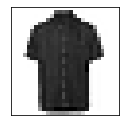

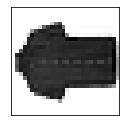

In [ ]:
index = 491

plt.figure(figsize=(2,2))
plt.imshow(X_train[index].reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.xticks(())
plt.yticks(())
plt.show()

plt.figure(figsize=(2,2))
plt.imshow(X_train_rot[index].reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.xticks(())
plt.yticks(())
plt.show()

## Create Pair of Samples with Similar and Dissimilar Images

So far, we created two types of data matrices: original samples & rotated samples. For each original sample in the data matrix, we have its rotated version in the rotated data matrix, at the same index.

Now, we will randomize half of the rotated data matrix such that 
- 50% of the original images will have their rotated versions at the same index
- 50% of the original images will have rotated versions of different images at the same index

This will allow us to compare the distance of the representations of the pairs of samples between the original and rotated data matrices. Specifically, in 50% pairs each image will have its rotated version (thus their representations should be the same) while in 50% pairs each image will have another image's rotated version (thus their representations should be different).

After shuffling half of the rotated data matrix (last 50%), we define a label list to store the true distances between the pairs.
- If a sample has its rotated version at the same index, then label = 0, otherwise 1

In [ ]:
'''
This function creates pairs of similar and dissimilar images & assigns new labels
'''   
def create_similar_dissimilar_pairs(X_rot, y_rot):
    '''
    Shuffling will done on the last 50% samples
    Get the begin and end index for sample shuffling
    '''
    index_begin = X_rot.shape[0] // 2
    index_end = X_rot.shape[0] 

    #print(index_begin)
    #print(index_end)

    '''
    Get a set of indices (from the last 50% samples) 
    that will be used to shuffle the corresponding samples
    '''
    indices = np.arange(index_begin, index_end)

    '''
    Shuffle the idices of last 50% samples
    '''
    np.random.shuffle(indices)


    '''
    Create a data and label matrix to store both the unshuffled
    and shuffled samples
    '''
    X_rot_suffled = X_rot.copy()
    y_rot_suffled = y_rot.copy()

    '''
    Create a label list as follows.
    - Label = 0: sample is unshuffled
    - Label = 1: sample is shuffled
    '''
    y_distance = np.ones(X_rot.shape[0])


    '''
    Using the shuffled indices for the last 50% samples,
    create a new data and label matrix that store both unshuffled 
    and shuffled samples and their labels
    Also update the label list to set whether a sample is shuffled or unshuffled
    '''
    for i in range(X_rot.shape[0]):
        if(i < index_begin):
            X_rot_suffled[i] = X_rot[i]
            y_rot_suffled[i] = y_rot[i]
            y_distance[i] = 0 # sample is unshuffled

        else:
            X_rot_suffled[i] = X_rot[indices[i-index_begin]]
            y_rot_suffled[i] = y_rot[indices[i-index_begin]]

            
    return X_rot_suffled, y_rot_suffled, y_distance 



## Create Data and Label Matrices for Storing the Rotated Images (last 50% images are shuffled)

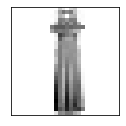

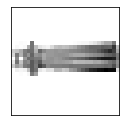

In [ ]:
'''
Create data and label matrices for storing the rotated images (last 50% images are shuffled)
'''
X_train_rot_shuffled, y_train_rot_shuffled, y_train_distance = create_similar_dissimilar_pairs(X_train_rot, y_train_rot)
X_test_rot_shuffled, y_test_rot_shuffled, y_test_distance = create_similar_dissimilar_pairs(X_test_rot, y_test_rot)
X_valid_rot_shuffled, y_valid_rot_shuffled, y_valid_distance = create_similar_dissimilar_pairs(X_valid_rot, y_valid_rot)

# Create int labels
y_train_distance = y_train_distance.astype(int)
y_test_distance = y_test_distance.astype(int)
y_valid_distance = y_valid_distance.astype(int)

'''
Visualize an original image and its rotated version
For the first half of the dataset, an image will have its rotated version at the same index.
'''

index = 250
image_original = X_valid[index]
image_rotated = X_valid_rot_shuffled[index]

plt.figure(figsize=(2,2))
plt.imshow(image_original.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.xticks(())
plt.yticks(())
plt.show()

plt.figure(figsize=(2,2))
plt.imshow(image_rotated.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.xticks(())
plt.yticks(())
plt.show()

## Create Categorical Labels for the Original Task

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_valid = tf.keras.utils.to_categorical(y_valid)

print("Shape of the training labels: ", y_train.shape)

Shape of the training labels:  (55000, 10)


## Functions for the MTL Approach

In [ ]:
'''
This function creates a base MLP network (shared layers) for learning shared representations
'''
def create_base_network(input_shape):
    input_ = tf.keras.Input(shape=input_shape)
    
    # Since the network is MLP, we need to flatten the input data
    input_flatten = tf.keras.layers.Flatten()(input_)
    hidden1 = tf.keras.layers.Dense(300, activation="relu")(input_flatten)
    hidden2 = tf.keras.layers.Dense(100, activation="relu")(hidden1)
    hidden2 = tf.keras.layers.Dropout(0.4)(hidden2)
    return tf.keras.models.Model(input_, hidden2)


'''
This function creates a base CNN (shallow) network (shared layers) for learning shared representations
'''
def create_base_network_cnn_shallow(input_shape):
    
    input_shape = (28, 28, 1)
    
    initializer = 'he_normal'
    activation_func = 'relu'
    
    input_ = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(16, (3, 3), kernel_initializer=initializer, padding='same', use_bias=False)(input_)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer=initializer, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    
    return tf.keras.models.Model(input_, x)



'''
This function creates a base CNN (deep) network (shared layers) for learning shared representations
'''
def create_base_network_cnn_deep(input_shape):
    
    input_shape = (28, 28, 1)
    
    initializer = 'he_normal'
    activation_func = 'relu'
    
    input_ = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer=initializer, padding='same', use_bias=False)(input_)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer=initializer, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    
    x = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer=initializer, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_func)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    return tf.keras.models.Model(input_, x)



'''
Compute the distance between two representations (feature vectors)
'''
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

'''
Define a contrastive loss function using the following equation.
Contrastive loss = mean((1-y_true) * square(y_pred) + y_true * square( max(margin-y_pred, 0) ))
Here:
y_true = it's the label of the pair of samples: positive pair = 0, negative pair = 1
y_pred = it's the Euclidean distance between the pair of samples

For positive pairs (y_true = 0): Loss = mean(square(y_pred))
For negative pairs (y_true = 1): Loss = mean(square( max(margin-y_pred, 0) ))
                                        if y_pred > margin (the dissimilar samples are far apart, i.e., > margin)
                                           so, Loss = 0
                                        if y_pred < margin (the dissimilar samples are close)
                                           so, Loss = margin-y_pred
'''
def contrastive_loss(y_true, y_pred): 
    # Convert the int y_true into a TF float
    y_true = tf.cast(y_true, tf.float32)
          
    margin = 1.0
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1.0 - y_true) * square_pred + (y_true) * margin_square
    )

## Experiment 1: the Siamese Network Minimizes the Distance of the Pairs of Embeddings via Contrastive Learning

First, we create the Siamese Network.

Model: "Experiment-1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128)          130592      ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 50)           6450        ['model[0][0]']       

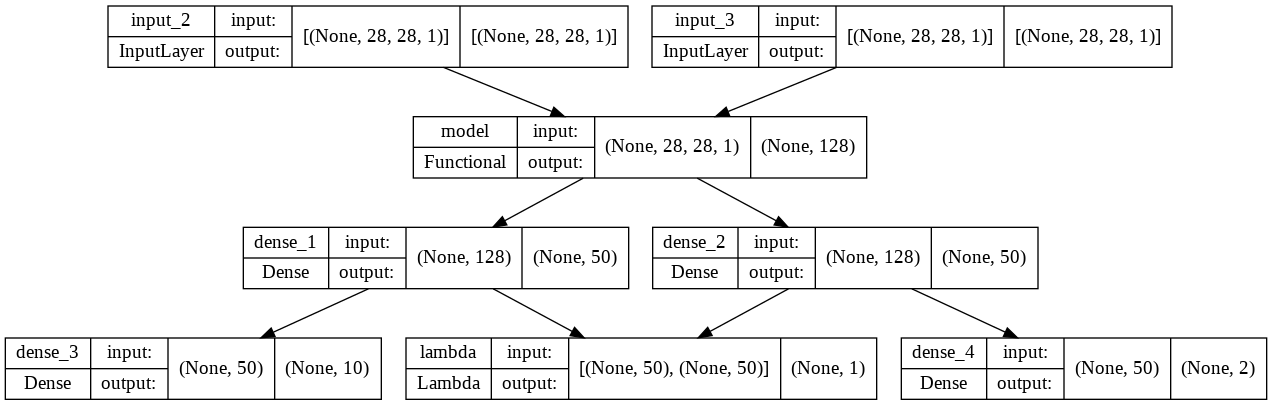

In [ ]:
'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)

input_shape = (28, 28, 1)

'''
Create the base network for learning shared representations
'''
base_network = create_base_network_cnn_deep(input_shape)


'''
Define the shape of the input for both tasks
'''
input_a = tf.keras.Input(shape=input_shape)
input_b = tf.keras.Input(shape=input_shape)

'''
Pass both inputs through the base network
It will create shared reprsentations
'''
processed_a = base_network(input_a)
processed_b = base_network(input_b)


'''
Create two task-specific Dense layers
'''
projection_head_1 = tf.keras.layers.Dense(50, activation="relu")(processed_a)
projection_head_2 = tf.keras.layers.Dense(50, activation="relu")(processed_b)

'''
Create a Lambda layer to compute the Euclidean distance between the representations of the input pairs
at the task-specific layer
'''
distance = tf.keras.layers.Lambda(euclidean_distance, output_shape=None)([projection_head_1, projection_head_2])


'''
Create a classification layer
'''
output1 = tf.keras.layers.Dense(10, activation="softmax")(projection_head_1)
output2 = tf.keras.layers.Dense(2, activation="softmax")(projection_head_2)


'''
Create a Model by specifying its input and outputs
'''
model_1 = tf.keras.models.Model(inputs=[input_a, input_b], outputs=[distance, output1, output2], name="Experiment-1")


'''
Display the model summary
'''
model_1.summary()

'''
Display the model graph
'''
tf.keras.utils.plot_model(model_1, show_shapes=True)

## Experiment 1: Compile & Train the Siamese Network Model

In [ ]:
%%time

'''
Define the optimizer
'''
#optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)
optimizer="adam"


'''
Compile the model.
Since labels for both tasks are categorical, we use the same loss function.
Otherwise we have to use specify the loss functions using a list.

Choice of loss function:
- contrastive_loss (we defined it earlier)
- categorical_crossentropy
'''
model_1.compile(loss=[contrastive_loss, "categorical_crossentropy", "categorical_crossentropy"],
              optimizer=optimizer,
              metrics=["accuracy"])


'''
Create a callback object of early stopping
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_dense_4_loss',
                                  min_delta=0, 
                                  patience=15, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

'''
Train the model.
We need to specify two types of labels for training and validation using lists.
'''
history_1 = model_1.fit([X_train, X_train_rot_shuffled], [y_train_distance, y_train, y_train_rot_shuffled], 
                    batch_size=64, 
                    epochs=150,
                    verbose=1,
                    validation_data=([X_valid, X_valid_rot_shuffled], [y_valid_distance, y_valid, y_valid_rot_shuffled]),
                    #callbacks=[early_stopping_cb]
                    )

Epoch 1/150
860/860 [==============================] - 25s 24ms/step - loss: 3.9839 - lambda_loss: 1.0031 - dense_3_loss: 2.2890 - dense_4_loss: 0.6918 - lambda_accuracy: 0.5045 - dense_3_accuracy: 0.1449 - dense_4_accuracy: 0.5419 - val_loss: 3.3043 - val_lambda_loss: 0.4342 - val_dense_3_loss: 2.1789 - val_dense_4_loss: 0.6912 - val_lambda_accuracy: 0.5040 - val_dense_3_accuracy: 0.2920 - val_dense_4_accuracy: 0.5528
Epoch 2/150
860/860 [==============================] - 19s 22ms/step - loss: 2.7487 - lambda_loss: 0.4182 - dense_3_loss: 1.7783 - dense_4_loss: 0.5522 - lambda_accuracy: 0.5345 - dense_3_accuracy: 0.3918 - dense_4_accuracy: 0.7384 - val_loss: 2.2476 - val_lambda_loss: 0.4363 - val_dense_3_loss: 1.3906 - val_dense_4_loss: 0.4207 - val_lambda_accuracy: 0.5540 - val_dense_3_accuracy: 0.4614 - val_dense_4_accuracy: 0.8612
Epoch 3/150
860/860 [==============================] - 19s 22ms/step - loss: 1.8188 - lambda_loss: 0.3735 - dense_3_loss: 1.1624 - dense_4_loss: 0.2829 - 

## Experiment 1: Evaluate the Siamese Network Model

In [ ]:
numOfEpochs = len(history_1.history['loss'])
print("Epochs: ", numOfEpochs)

print("\n******************** Multiclass Classification ********************************************")


'''
Prediction for test data
'''
# model.predict() method returns C probabilities per class for each instance (Dimension NxC), where C = #classes
y_test_predicted = model_1.predict([X_test, X_test_rot_shuffled])
y_test_predicted_multiclass = np.argmax(y_test_predicted[1], axis=1) # get the label/index of the highest probability class
y_test_predicted_binary = np.argmax(y_test_predicted[2], axis=1) # get the label/index of the highest probability class


'''
Prediction for training data
'''
y_train_predicted = model_1.predict([X_train, X_train_rot_shuffled])
y_train_predicted_multiclass = np.argmax(y_train_predicted[1], axis=1) # get the label/index of the highest probability class
y_train_predicted_binary = np.argmax(y_train_predicted[2], axis=1) # get the label/index of the highest probability class



'''
Get the integer labels for the multiclass data
'''
y_test_multiclass = np.argmax(y_test, axis=1) # get the label/index of the highest probability class
y_train_multiclass = np.argmax(y_train, axis=1) # get the label/index of the highest probability class


'''
Compute the train & test accuracies for the multiclass data
'''
train_accuracy_multiclass = accuracy_score(y_train_predicted_multiclass, y_train_multiclass)
test_accuracy_multiclass_1 = accuracy_score(y_test_predicted_multiclass, y_test_multiclass)


print("\nMulticlass Classification - Train Accuracy: ", train_accuracy_multiclass)
print("Multiclass Classification - Test Accuracy: ", test_accuracy_multiclass_1)


print("\nTest Confusion Matrix (Multiclass):")
print(confusion_matrix(y_test_multiclass, y_test_predicted_multiclass))

print("\nClassification Report (Multiclass):")
print(classification_report(y_test_multiclass, y_test_predicted_multiclass))



print("\n******************** Binary Classification ********************************************")


'''
Get the integer labels for the binary data
'''
y_train_rot_binary = np.argmax(y_train_rot_shuffled, axis=1) # get the label/index of the highest probability class
y_test_rot_binary = np.argmax(y_test_rot_shuffled, axis=1) # get the label/index of the highest probability class


train_accuracy_binary = accuracy_score(y_train_rot_binary, y_train_predicted_binary)
test_accuracy_binary = accuracy_score(y_test_rot_binary, y_test_predicted_binary)

print("\nBinary Classification - Train Accuracy: ", train_accuracy_binary)
print("Binary Classification - Test Accuracy: ", test_accuracy_binary)


print("\nTest Confusion Matrix (Binary):")
print(confusion_matrix(y_test_rot_binary, y_test_predicted_binary))

print("\nClassification Report (Binary):")
print(classification_report(y_test_rot_binary, y_test_predicted_binary))

Epochs:  150

******************** Multiclass Classification ********************************************

Multiclass Classification - Train Accuracy:  0.9434181818181818
Multiclass Classification - Test Accuracy:  0.9225

Test Confusion Matrix (Multiclass):
[[883   0  16  16   6   1  76   0   2   0]
 [  0 981   2  11   5   0   1   0   0   0]
 [ 19   1 873   7  67   0  33   0   0   0]
 [  6   1  10 935  27   0  21   0   0   0]
 [  1   0  12  18 933   0  36   0   0   0]
 [  0   0   0   0   0 976   0  21   0   3]
 [ 98   0  44  27  91   0 739   0   1   0]
 [  0   0   0   0   0   1   0 988   0  11]
 [  0   0   8   5   0   5   5   4 973   0]
 [  1   0   0   0   0   4   0  51   0 944]]

Classification Report (Multiclass):
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1000
           1       1.00      0.98      0.99      1000
           2       0.90      0.87      0.89      1000
           3       0.92      0.94      0.93      1000
  

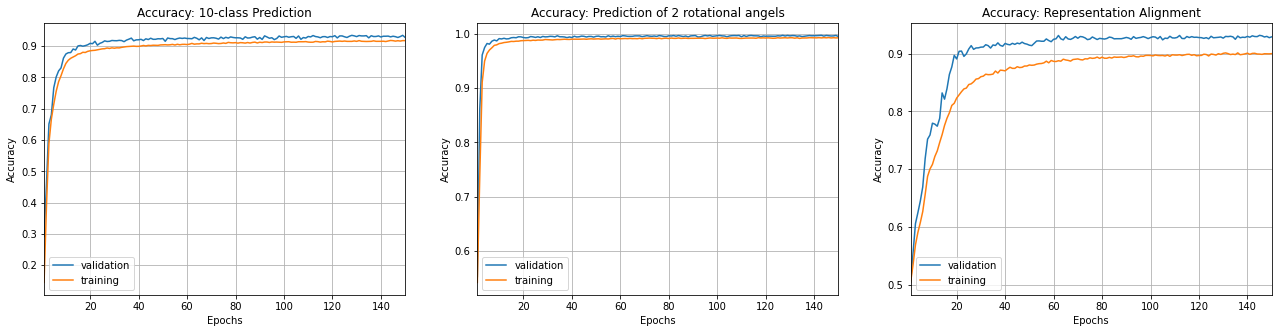

In [ ]:
plt.figure(figsize=(22,5))

plt.subplot(131)
plt.plot(range(1,numOfEpochs+1),history_1.history['val_dense_3_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history_1.history['dense_3_accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Accuracy: 10-class Prediction")

plt.subplot(132)
plt.plot(range(1,numOfEpochs+1),history_1.history['val_dense_4_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history_1.history['dense_4_accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Accuracy: Prediction of 2 rotational angels")


plt.subplot(133)
plt.plot(range(1,numOfEpochs+1),history_1.history['val_lambda_accuracy'],label='validation')
plt.plot(range(1,numOfEpochs+1),history_1.history['lambda_accuracy'],label='training')
plt.legend(loc=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([1,numOfEpochs])
plt.grid(True)
plt.title("Accuracy: Representation Alignment")


plt.show() 

## Experiment 2: the Siamese Network Does not Minimize the Distance of the Pairs of Embeddings

Model: "Experiment-2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128)          130592      ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 50)           6450        ['model[0][0]']       

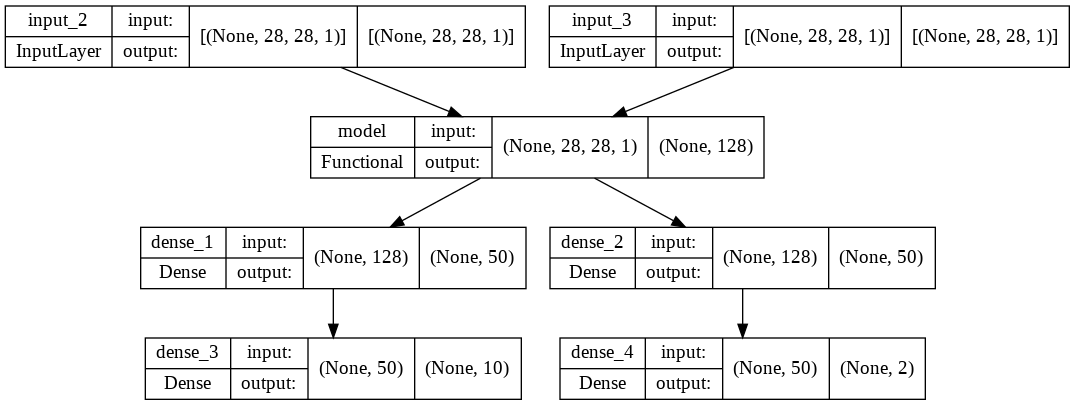

In [ ]:
'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)

input_shape = (28, 28, 1)

'''
Create the base network for learning shared representations
'''
base_network = create_base_network_cnn_deep(input_shape)


'''
Define the shape of the input for both tasks
'''
input_a = tf.keras.Input(shape=input_shape)
input_b = tf.keras.Input(shape=input_shape)

'''
Pass both inputs through the base network
It will create shared reprsentations
'''
processed_a = base_network(input_a)
processed_b = base_network(input_b)



'''
Create two task-specific layers
'''
projection_head_1 = tf.keras.layers.Dense(50, activation="relu")(processed_a)
projection_head_2 = tf.keras.layers.Dense(50, activation="relu")(processed_b)

'''
Create a classification layer
'''
output1 = tf.keras.layers.Dense(10, activation="softmax")(projection_head_1)
output2 = tf.keras.layers.Dense(2, activation="softmax")(projection_head_2)


'''
Create a Model by specifying its input and outputs
'''

model_2 = tf.keras.models.Model(inputs=[input_a, input_b], outputs=[output1, output2], name="Experiment-2")

'''
Display the model summary
'''
model_2.summary()

'''
Display the model graph
'''
tf.keras.utils.plot_model(model_2, show_shapes=True)

## Experiment 2: Compile & Train the Siamese Network Model

In [ ]:
%%time

'''
Define the optimizer
'''
#optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)
optimizer="adam"


'''
Compile the model.
Since labels for both tasks are categorical, we use the same loss function.
Otherwise we have to use specify the loss functions using a list.
'''

model_2.compile(loss=["categorical_crossentropy", "categorical_crossentropy"],
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Create a callback object of early stopping
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_dense_4_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

'''
Train the model.
We need to specify two types of labels for training and validation using lists.
'''
history_2 = model_2.fit([X_train, X_train_rot_shuffled], [y_train, y_train_rot_shuffled], 
                    batch_size=64, 
                    epochs=150,
                    verbose=1,
                    validation_data=([X_valid, X_valid_rot_shuffled], [y_valid, y_valid_rot_shuffled]),
                    #callbacks=[early_stopping_cb]
                    )

Epoch 1/150
860/860 [==============================] - 20s 21ms/step - loss: 1.0593 - dense_3_loss: 0.8381 - dense_4_loss: 0.2212 - dense_3_accuracy: 0.6903 - dense_4_accuracy: 0.9126 - val_loss: 0.5184 - val_dense_3_loss: 0.4578 - val_dense_4_loss: 0.0606 - val_dense_3_accuracy: 0.8350 - val_dense_4_accuracy: 0.9784
Epoch 2/150
860/860 [==============================] - 17s 20ms/step - loss: 0.6439 - dense_3_loss: 0.5380 - dense_4_loss: 0.1060 - dense_3_accuracy: 0.8018 - dense_4_accuracy: 0.9615 - val_loss: 0.4186 - val_dense_3_loss: 0.3757 - val_dense_4_loss: 0.0429 - val_dense_3_accuracy: 0.8558 - val_dense_4_accuracy: 0.9844
Epoch 3/150
860/860 [==============================] - 17s 20ms/step - loss: 0.5375 - dense_3_loss: 0.4571 - dense_4_loss: 0.0804 - dense_3_accuracy: 0.8318 - dense_4_accuracy: 0.9717 - val_loss: 0.3489 - val_dense_3_loss: 0.3146 - val_dense_4_loss: 0.0343 - val_dense_3_accuracy: 0.8830 - val_dense_4_accuracy: 0.9862
Epoch 4/150
860/860 [======================

## Experiment 2: Evaluate the Siamese Network Model

In [ ]:
numOfEpochs = len(history_2.history['loss'])
print("Epochs: ", numOfEpochs)

print("\n******************** Multiclass Classification ********************************************")


'''
Prediction for test data
'''

# model.predict() method returns C probabilities per class for each instance (Dimension NxC), where C = #classes
y_test_predicted = model_2.predict([X_test, X_test_rot_shuffled])
y_test_predicted_multiclass = np.argmax(y_test_predicted[0], axis=1) # get the label/index of the highest probability class
y_test_predicted_binary = np.argmax(y_test_predicted[1], axis=1) # get the label/index of the highest probability class


'''
Prediction for training data
'''
y_train_predicted = model_2.predict([X_train, X_train_rot_shuffled])
y_train_predicted_multiclass = np.argmax(y_train_predicted[0], axis=1) # get the label/index of the highest probability class
y_train_predicted_binary = np.argmax(y_train_predicted[1], axis=1) # get the label/index of the highest probability class



'''
Get the integer labels for the multiclass data
'''
y_test_multiclass = np.argmax(y_test, axis=1) # get the label/index of the highest probability class
y_train_multiclass = np.argmax(y_train, axis=1) # get the label/index of the highest probability class


'''
Compute the train & test accuracies for the multiclass data
'''
train_accuracy_multiclass = accuracy_score(y_train_predicted_multiclass, y_train_multiclass)
test_accuracy_multiclass_2 = accuracy_score(y_test_predicted_multiclass, y_test_multiclass)


print("\nMulticlass Classification - Train Accuracy: ", train_accuracy_multiclass)
print("Multiclass Classification - Test Accuracy: ", test_accuracy_multiclass_2)


print("\nTest Confusion Matrix (Multiclass):")
print(confusion_matrix(y_test_multiclass, y_test_predicted_multiclass))

print("\nClassification Report (Multiclass):")
print(classification_report(y_test_multiclass, y_test_predicted_multiclass))



print("\n******************** Binary Classification ********************************************")


'''
Get the integer labels for the binary data
'''
y_train_rot_binary = np.argmax(y_train_rot_shuffled, axis=1) # get the label/index of the highest probability class
y_test_rot_binary = np.argmax(y_test_rot_shuffled, axis=1) # get the label/index of the highest probability class


train_accuracy_binary = accuracy_score(y_train_rot_binary, y_train_predicted_binary)
test_accuracy_binary = accuracy_score(y_test_rot_binary, y_test_predicted_binary)

print("\nBinary Classification - Train Accuracy: ", train_accuracy_binary)
print("Binary Classification - Test Accuracy: ", test_accuracy_binary)


print("\nTest Confusion Matrix (Binary):")
print(confusion_matrix(y_test_rot_binary, y_test_predicted_binary))

print("\nClassification Report (Binary):")
print(classification_report(y_test_rot_binary, y_test_predicted_binary))

Epochs:  150

******************** Multiclass Classification ********************************************

Multiclass Classification - Train Accuracy:  0.9527818181818182
Multiclass Classification - Test Accuracy:  0.9264

Test Confusion Matrix (Multiclass):
[[888   0  21  21   4   1  63   0   2   0]
 [  0 988   3   8   1   0   0   0   0   0]
 [ 17   1 895   7  56   0  24   0   0   0]
 [  6   2  15 940  27   0  10   0   0   0]
 [  0   0  27  15 927   0  31   0   0   0]
 [  0   0   0   0   0 969   0  28   0   3]
 [ 97   1  67  26  74   0 733   0   2   0]
 [  0   0   0   0   0   0   0 992   0   8]
 [  1   0   3   3   4   1   2   7 978   1]
 [  1   0   0   0   0   4   0  41   0 954]]

Classification Report (Multiclass):
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1000
           1       1.00      0.99      0.99      1000
           2       0.87      0.90      0.88      1000
           3       0.92      0.94      0.93      1000
  

## Experiment 3: Vanilla Network Trained on Original Data

Model: "Experiment-3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 128)               130592    
                                                                 
 dense_1 (Dense)             (None, 50)                6450      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
Total params: 137,552
Trainable params: 136,976
Non-trainable params: 576
_________________________________________________________________


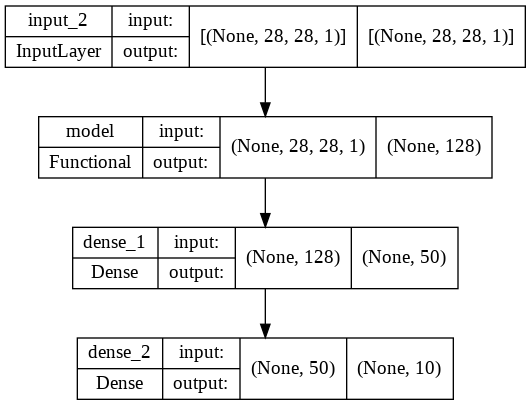

In [ ]:
'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)

input_shape = (28, 28, 1)

'''
Create the base network for learning shared representations
'''
base_network = create_base_network_cnn_deep(input_shape)


'''
Define the shape of the input 
'''
input_ = tf.keras.Input(shape=input_shape)


'''
Pass input through the base network
'''
processed = base_network(input_)


'''
Add a dense layer (similar to the task-specific layer in the Siamese network)
'''
projection_head = tf.keras.layers.Dense(50, activation="relu")(processed)


'''
Add a classsification layer
'''
output = tf.keras.layers.Dense(10, activation="softmax")(projection_head)




# input_shape = (28, 28)
# model_3 = tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(input_shape=input_shape),
#     tf.keras.layers.Dense(100, activation="relu"),
#     tf.keras.layers.Dense(50, activation="relu"),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(10, activation="softmax")
# ])



'''
Create a Model by specifying its input and outputs
'''
model_3 = tf.keras.models.Model(inputs=input_, outputs=output, name="Experiment-3")


'''
Display the model summary
'''
model_3.summary()

'''
Display the model graph
'''
tf.keras.utils.plot_model(model_3, show_shapes=True)

## Experiment 3: Compile & Train the Vanilla Neural Network

In [ ]:
'''
Define the optimizer
'''
#optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1, momentum=0.1)
optimizer="adam"


'''
Compile the model.
Since labels for both tasks are categorical, we use the same loss function.
Otherwise we have to use specify the loss functions using a list.
'''

model_3.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])



'''
Create a callback object of early stopping
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

'''
Train the model.
We need to specify two types of labels for training and validation using lists.
'''
history_3 = model_3.fit(X_train, y_train, 
                    batch_size=64, 
                    epochs=150,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    #callbacks=[early_stopping_cb]
                    )

Epoch 1/150
860/860 [==============================] - 10s 11ms/step - loss: 0.8013 - accuracy: 0.7049 - val_loss: 0.4233 - val_accuracy: 0.8462
Epoch 2/150
860/860 [==============================] - 9s 11ms/step - loss: 0.5082 - accuracy: 0.8130 - val_loss: 0.3373 - val_accuracy: 0.8752
Epoch 3/150
860/860 [==============================] - 9s 11ms/step - loss: 0.4385 - accuracy: 0.8383 - val_loss: 0.3071 - val_accuracy: 0.8862
Epoch 4/150
860/860 [==============================] - 9s 10ms/step - loss: 0.3972 - accuracy: 0.8551 - val_loss: 0.2785 - val_accuracy: 0.8984
Epoch 5/150
860/860 [==============================] - 9s 10ms/step - loss: 0.3667 - accuracy: 0.8662 - val_loss: 0.2676 - val_accuracy: 0.9038
Epoch 6/150
860/860 [==============================] - 9s 10ms/step - loss: 0.3512 - accuracy: 0.8723 - val_loss: 0.2824 - val_accuracy: 0.8982
Epoch 7/150
860/860 [==============================] - 9s 11ms/step - loss: 0.3354 - accuracy: 0.8797 - val_loss: 0.2414 - val_accuracy

## Experiment 3: Evaluate the Vanilla Neural Network

In [ ]:
y_test_predicted = model_3.predict(X_test)
y_test_predicted_multiclass = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


'''
Get the integer labels for the multiclass data
'''
y_test_multiclass = np.argmax(y_test, axis=1) # get the label/index of the highest probability class


'''
Compute the train & test accuracies for the multiclass data
'''
test_accuracy_multiclass_3 = accuracy_score(y_test_predicted_multiclass, y_test_multiclass)


print("Experiment 3 - Test Accuracy: ", test_accuracy_multiclass_3)

print("\nExperiment 3 - Confusion Matrix")
print(confusion_matrix(y_test_predicted_multiclass, y_test_multiclass))

Experiment 3 - Test Accuracy:  0.9301

Experiment 3 - Confusion Matrix
[[884   0  19  11   0   0  86   0   1   0]
 [  0 991   1   2   0   0   1   0   0   0]
 [ 14   0 858   7  10   0  38   0   1   0]
 [ 13   6   8 938  15   0  24   0   2   0]
 [  4   2  68  24 937   0  66   0   2   0]
 [  0   0   0   0   0 981   0   3   3   3]
 [ 82   0  46  18  38   0 780   0   1   0]
 [  0   0   0   0   0  15   0 989   1  42]
 [  3   1   0   0   0   0   5   0 989   1]
 [  0   0   0   0   0   4   0   8   0 954]]


## Evaluating the Models from 3 Experiments on the Augmented (Rotated) Data

In [ ]:
'''
Get the multiclass predictions for the augmented (rotated) test data
'''
y_test_predicted_1 = model_1.predict([X_test_rot, X_test_rot])
y_test_predicted_multiclass_rot_1 = np.argmax(y_test_predicted_1[1], axis=1) # get the label/index of the highest probability class

y_test_predicted_2 = model_2.predict([X_test_rot, X_test_rot])
y_test_predicted_multiclass_rot_2 = np.argmax(y_test_predicted_2[0], axis=1) # get the label/index of the highest probability class

y_test_predicted_3 = model_3.predict(X_test_rot)
y_test_predicted_multiclass_rot_3 = np.argmax(y_test_predicted_3, axis=1) # get the label/index of the highest probability class


'''
Get the integer labels for the multiclass training data
'''
y_test_multiclass_rot = np.argmax(y_test, axis=1) # get the label/index of the highest probability class


'''
Compute the train & test accuracies for the multiclass augmented (rotated) data
'''
test_accuracy_multiclass_rot_1 = accuracy_score(y_test_predicted_multiclass_rot_1, y_test_multiclass_rot)
test_accuracy_multiclass_rot_2 = accuracy_score(y_test_predicted_multiclass_rot_2, y_test_multiclass_rot)
test_accuracy_multiclass_rot_3 = accuracy_score(y_test_predicted_multiclass_rot_3, y_test_multiclass_rot)

print("\nMulticlass Test Accuracy: Original Data:")
print("Experiment 1 - Test Accuracy: ", test_accuracy_multiclass_1)
print("Experiment 2 - Test Accuracy: ", test_accuracy_multiclass_2)
print("Experiment 3 - Test Accuracy: ", test_accuracy_multiclass_3)

print("\nMulticlass Test Accuracy: Augmented (rotated) Data:")
print("Experiment 1 - Test Accuracy: ", test_accuracy_multiclass_rot_1)
print("Experiment 2 - Test Accuracy: ", test_accuracy_multiclass_rot_2)
print("Experiment 3 - Test Accuracy: ", test_accuracy_multiclass_rot_3)


print("\nMulticlass Test Confusion Matrix: Augmented (rotated) Data:")
print("\nExperiment 1 - Confusion Matrix")
print(confusion_matrix(y_test_predicted_multiclass_rot_1, y_test_multiclass_rot))

print("\nExperiment 2 - Confusion Matrix")
print(confusion_matrix(y_test_predicted_multiclass_rot_2, y_test_multiclass_rot))

print("\nExperiment 3 - Confusion Matrix")
print(confusion_matrix(y_test_predicted_multiclass_rot_3, y_test_multiclass_rot))



Multiclass Test Accuracy: Original Data:
Experiment 1 - Test Accuracy:  0.9225
Experiment 2 - Test Accuracy:  0.9264
Experiment 3 - Test Accuracy:  0.9301

Multiclass Test Accuracy: Augmented (rotated) Data:
Experiment 1 - Test Accuracy:  0.2692
Experiment 2 - Test Accuracy:  0.1572
Experiment 3 - Test Accuracy:  0.1479

Multiclass Test Confusion Matrix: Augmented (rotated) Data:

Experiment 1 - Confusion Matrix
[[ 54   6 162  43 191  42  69  17   4 405]
 [  7 142   0  43   0   4   2   3  32   1]
 [140   1 492  15 359   0 214   0 137   0]
 [ 21 337  18 364  41  21  14  43   9   7]
 [  8   2   5  26  49   0  18   4  40   0]
 [ 10 477   2  11   3 915   2 916 194 569]
 [280   5  58  30 187   0 373   0  84   4]
 [ 12   5   1 290  25   0   9   0  23   0]
 [465  25 262 178 145  16 297  17 303  14]
 [  3   0   0   0   0   2   2   0 174   0]]

Experiment 2 - Confusion Matrix
[[ 69  13 148  49  50 259  54  44  39 715]
 [ 17  96  34 117  29  79  24 206  85  64]
 [  7   0  10  10   6   3   8   0

## Observation

We achieved substantially better classification performance in experiment 2, i.e., by using the Siamese Network architecture that does not minimize the distance of the pairs of embeddings. Thus, it seems that for the MNIST fashion dataset, minimizing the distance of the embeddings is not useful. Learning a shared embedding space appears to be more effective.